<font color="purple"/>
## Yapay Sinir Ağları - 1188132111 

# RNN (Recurrent Neural Network)

<font color="black"/>
Tekrarlayan bir sinir ağı (RNN), düğümler arasındaki bağlantıların geçici bir dizi boyunca yönlendirilmiş bir grafik oluşturduğu bir yapay sinir ağı sınıfıdır.<br>
İleri beslemeli sinir ağlarından türetilen RNN'ler, değişken uzunluklu giriş dizilerini işlemek için dahili durumlarını (belleklerini) kullanabilirler.
<p> Bu yaklaşım <strong> sıralı veriler</strong> için faydalıdır.<br>
Çünkü her nöron ya da ünite bir önceki girdi ile ilgili bilgileri korumak için dahili belleği kullanır.<br><strong> RNN'in eski (önceki) bilgileri kullanımına dayalı bir yaklaşımı vardır.</strong><br>
Mesela "Havuç toprakta yetişir" cümlesi olsun ve buradaki "toprak" kelimesini tahmin etmek kolaydır.<br>
    Fakat bağlamlar arası boşluk arttığında RNN modelinin geçmişten gelen bir bilgiyi kullanması oldukça zordur.<br>
    Bu problemi çözmek için uzun vadeli bağımlılıkları öğrenebilen ve <strong> özel bir RNN türü</strong>olan LSTM sıklıkla kullanılmakta.<br>
    LSTM, RNN'in bir türüdür ve bu iki kavram birbiri ile ilişkilidir.<br>
</p> 

Bu çalışmada kullanacağım dataset <a href="https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data?select=IMDB+Dataset.csv">Kaggle IMDB</a> datasetidir. <br>

Veri kümesini indirir ve sıkıştırılmış dosyayı çıkarırsanız, bir CSV dosyası görürsünüz. Dosya 50.000 kayıt ve iki sütun içerir: review ve sentiment. Sentiment sütunu 2 values içerir -> positive ve negative <br>


<p style="color:pink;">Duygu sütununun iki değeri var dedik, yani "pozitif" ve "negatif", bu da sorunumuzu ikili bir sınıflandırma problemi haline getirir. </p>
<hr> 

* [Gerekli kütüphanelerin yüklenmesi](#1)
* [Datasetin yüklenmesi ve incelenmesi](#2)
* [Data Preprocessing (Veri Önişleme)](#3)
* [Preparing the Embedding Layer (Gömme Katmanının Hazırlanması)](#4)
* [Text Classification with Simple Neural Network](#5)
* [RNN & LSTM](#6)

<a id="1"></a>

<font color="purple"/>

# Gerekli Kütüphanelerin Yüklenmesi

In [39]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer


<a id="2"></a>

<font color="purple"/>

# Datasetin Yüklenmesi ve İncelenmesi

<font color="black"/>

Şimdi veri setimizi içe aktaralım ve analiz edelim. <br>

Aşağıdaki komut dosyasında, veri setimizi içeren CSV dosyasını okumak için pandas kütüphanesinin read_csv () yöntemini kullanıyoruz. Bir sonraki satırda, veri kümesinin NULL değeri içerip içermediğini kontrol ediyoruz. Son olarak, veri setimizin şeklini yazdırıyoruz.

In [5]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

movie_reviews.isnull().values.any()
# Bu datasetin içerisinde herhangi boş bir değer var mı ?

False

In [6]:
movie_reviews.shape # satır-sütun bilgisi

(50000, 2)

In [7]:
# Evet movie_reviews datasetimizde 2 sütun (review ve sentiment) ve 50000 gözlem varmış

In [8]:
movie_reviews.head() #  Şimdi head () yöntemini kullanarak veri kümesinin ilk 5 satırını yazdıralım.
# Çıktıda aşağıdaki veri çerçevesini göreceksiniz:

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Bakın review verisi stringlerden oluşuyor ve bu metin verisinin üzerinde işlem yapmamız için veriyi temizlemeliyiz.

In [9]:
# Şimdi incelemelerden herhangi birine bir göz atalım, böylece işleyeceğimiz metin hakkında bir fikrimiz var. 
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<font color="green" size="3"/>
Metnimizde noktalama işaretleri, köşeli parantezler ve birkaç HTML etiketi de olduğunu görebilirsiniz. Bir sonraki bölümde bu metni ön işleyeceğiz. <br>

Son olarak, veri setimizde pozitif ve negatif duyguların dağılımını görelim.

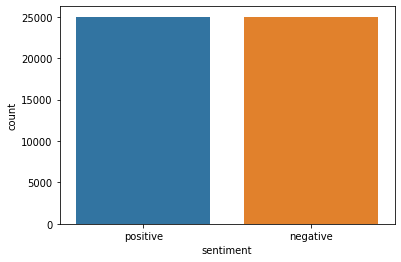

In [10]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)
# seaborn veri görselleştirme kütüphanesini kullandım.

In [11]:
#Çıktıdan, veri kümesinin eşit sayıda olumlu ve olumsuz yorum içerdiğini görüyoruz
# toplamda 50.000 gözlemimiz vardı
# 25.000 pozitif ve 25.000 negatif olarak dağılmış durumda

<a id="3"></a>

<font color="purple"/>

# Data Preprocessing

<hr>

<font color="brown" size="3" />
Veri kümemizin noktalama işaretleri ve HTML etiketleri içerdiğini gördük.<br>
Bu bölümde, bir text stringi parametre olarak alan ve daha sonra özel karakterleri ve HTML etiketlerini text stringinden kaldırmak için veri önişleme gerçekleştiren bir fonksiyon tanımlayacağız.<br>

In [12]:
def preprocess_text(sen):
    # Metinimiz içerisinde çeşitli html tagları vardı
    # Bu fonksiyon içine her sentence tek tek girecek ve temizlenecek
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [13]:
# Cümle oluşturduğumuz fonksiyona girecek ve temizlenmiş olarak çıkacak

<font color="brown" size="3" />

Preprocess_text () yönteminde ilk adım HTML etiketlerini kaldırmaktır.<br>
HTML etiketlerini kaldırmak için remove_tags () fonksiyonu kullanıldı. <br>
Remove_tags fonksiyonu, <> açma ve kapatma arasındaki herhangi bir şeyi boş bir alanla değiştirir. <br>
Sonra, preprocess_text fonksiyonunda, büyük ve küçük  harfler hariç her şey kaldırır, bu da anlamsız olan tek karakterlerle sonuçlanır.<br>
Daha sonra, tüm tek karakterleri kaldırırız ve bunu metnimizde birden çok boşluk içeren her cümle, bir boşlukla değiştirilir.<br> Son olarak, birden fazla boşluğu da metnimizden kaldırıyoruz.

In [14]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

<font color="brown" size="3" />
Daha sonra, "review"ları ön işleyeceğiz ve aşağıda gösterildiği gibi yeni bir listede saklayacağız:
Aşağıda movie_reviews['review'] dediğimizde bize <strong> review </strong> sütunundaki tüm gözlemleri yani her satır değerini getirir. <br>
list(movie_reviews['review']) dediğimizde de her gözlemi bir listeye çevirir. <br>
Biz bu liste yapısını sentence adlı değişkene atadık.<br>
Daha sonra bu sentence'ı yukarıda önceden oluşturduğumuz fonksiyonun içerisine soktuk ve temizledik!<br>
Bu sonucuda bir liste (X) yapısına ekledik

In [15]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [62]:
X[4]

'Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acting is good under

<font color="green" size="3"/>
Çıktıdan HTML etiketlerinin, noktalama işaretlerinin ve sayıların kaldırıldığını görebilirsiniz.<br>
Sadece alfabelerle kaldık :).<br>
Ardından, etiketlerimizi rakamlara dönüştürmemiz gerekiyor.<br>
Çıktıda sadece iki etiket var, yani "pozitif" ve "negatif".<br>
<strong>Aşağıda gösterildiği gibi "pozitif" değerini 1 rakamı ve negatifi 0 rakamı ile değiştirerek tamsayılara dönüştürebiliriz:</strong><br>

In [17]:
y = movie_reviews['sentiment'] # sentiment sütunundaki gözlemleri y'ye atadık

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

<font color="green" size="3"/>
Son olarak, veri setimizi train ve test setlerine ayırmamız gerekiyor.<br>
<b>Train seti, derin öğrenme modellerimizi eğitirken,test seti de modelimizin ne kadar iyi performans gösterdiğini değerlendirmek için kullanılacaktır.</b> <br>

Aşağıda gösterildiği gibi sklearn.model.selection modülünden <b>train_test_split</b> yöntemini kullanabiliriz:<br>

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

<font color="green" size="3"/>
Yukarıdaki komut dosyası verilerimizi eğitim seti için% 80'e ve test seti için% 20'ye böler. <br>
Şimdi gömme katmanımızın komut dosyasını yazalım.<b> Gömme katmanı, metinsel verilerimizi sayısal verilere dönüştürür </b> ve Keras'taki derin öğrenme modelleri için ilk katman olarak kullanılır.

<a id="4"></a>

<font color="purple">
    
# Preparing the Embedding Layer 

<font color="black" size="3">
    
İlk adım olarak, word-to-index dictionary oluşturmak için keras.preprocessing.text modülünden <b> Tokenizer </b> sınıfını kullanacağız.<br>

word-to-index dictionary'de, gruptaki her sözcük bir anahtar olarak kullanılırken, karşılık gelen benzersiz bir index anahtarın değeri olarak kullanılır. Yani kelimeleri indexleyerek bir dictionary yapısı oluşturacağız:

In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

<font color="green" size="3"/>
X_train değişkenini görüntülerseniz, her listenin tamsayılar içerdiği 40.000 liste içerdiğini göreceksiniz.<br>
<b>Her liste aslında eğitim setindeki her cümleye karşılık gelir.</b> Ayrıca, <b>her bir listenin boyutunun farklı</b> olduğunu fark edeceksiniz. <b>Çünkü cümlelerin uzunlukları farklıdır.</b> <br>
<font color="purple" size="3"/>
Her listenin maksimum boyutunu 100 olarak ayarladık. Farklı bir boyut denenebilir ben bu şekilde seçtim.<br>
100'den büyük boyutlu listeler 100'e kısaltılır<br>
<b>Uzunluğu 100'den az olan listeler için, listenin sonuna maksimum uzunluğa ulaşıncaya kadar 0 ekleyeceğiz.
Bu işleme dolgu(padding) adı verilir.</b>

Aşağıdaki komut dosyası kelime boyutunu bulur ve ardından hem train hem de test setinde dolgu (padding> gerçekleştirir.

In [20]:
#1 ekleniyor çünkü index yapısı 0'dan başlar
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

<font color="purple" size="3"/>

Şimdi X_train veya X_test'i görüntülerseniz, tüm listelerin aynı uzunluğa, yani 100'e sahip olduğunu göreceksiniz. <br>
Ayrıca, kelime hazinesi_boyut değişkeni artık 92547 değerini içerir, bu da derlememizde 92547 benzersiz kelime olduğu anlamına gelir.<br>
Özellik matrisimizi oluşturmak için GloVe düğünlerini kullanacağız. <br> Aşağıdaki komut dosyasında GloVe kelime düğünlerini yükler ve anahtar olarak kelimeleri ve karşılık gelen gömme listesini değerler olarak içeren bir sözlük oluştururuz.

<font size="4"/>

<a href="https://www.kaggle.com/terenceliu4444/glove6b100dtxt"> Bu linkten glove düğümlerini indirin</a>

In [26]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")
# buradaki glove.6B.100d.txt dosyasını kaggledan indirdik ve açtık

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

<font color="blue" size="3"/>
Son olarak, her satır numarasının korpustaki kelimenin dizinine karşılık geleceği bir gömme matrisi oluşturacağız. Matris, her sütunun, topluluğumuzdaki kelimeler için GloVe kelime düğünlerini içereceği 100 sütuna sahip olacaktır.

In [27]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Yukarıdaki komut dosyasını yürüttüğünüzde, embedding_matrix öğesinin 92547 satır içerdiğini göreceksiniz (gruptaki her sözcük için bir tane).<br> Şimdi derin öğrenme modellerimizi yaratmaya hazırız.

<a id="4"></a>

<font color="purple">
    
# Text Classification with Simple Neural Network

<font color="black" size="3"/>
Geliştireceğimiz ilk derin öğrenme modeli, basit bir derin sinir ağıdır.<br>
Aşağıdaki komut dosyasında, bir Sequential () model oluşturuyoruz.<br>
Sonra, gömme katmanımızı yaratırız. Gömme katmanı 100 giriş uzunluğuna sahip olacak, çıkış vektörü boyutu da 100 olacak. <br>
Kelime boyutu 92547 kelime olacak. <br>
Kendi düğünlerimizi eğitmediğimiz ve GloVe gömmeyi kullanmadığımız için,  trainable "False" hale getirdik ve ağırlık özelliğinden(weight) kendi gömme matrisimizi (embedding_matrix) geçiyoruz. <br>


In [28]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [29]:
# Son olarak, sigmoid aktivasyon fonksiyonu ile yoğun bir katman ekliyoruz.

In [30]:
# Modelimizi derlemek için adam optimizer, binary_crossentropy'yi kayıp fonksiyonumuz (loss func)
# ve accuracy olarak metrics  kullanacağız ve sonra modelimizin özetini yazdıracağız:


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


<font color="purple" size="3"/>
Topluluğumuzda 92547 kelime bulunduğundan ve her kelime 100 boyutlu bir vektör olarak temsil edildiğinden, gömülebilir katmanda eğitilebilir parametre sayısı 92547x100 olacaktır.<br> Düzleştirme katmanında, sadece satırları ve sütunu çoğaltırız.
<hr>
Son olarak yoğun tabakada parametre sayısı 10000 (düzleştirme tabakasından) ve sapma parametresi için 1'dir, toplam 10001'dir. Şimdi modelimizi eğitelim:

In [31]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 2s 54us/step - loss: 0.6050 - acc: 0.6689 - val_loss: 0.5455 - val_acc: 0.7140
Epoch 2/6
32000/32000 [==============================] - 1s 33us/step - loss: 0.4970 - acc: 0.7608 - val_loss: 0.5383 - val_acc: 0.7290
Epoch 3/6
32000/32000 [==============================] - 1s 34us/step - loss: 0.4605 - acc: 0.7860 - val_loss: 0.5159 - val_acc: 0.7465
Epoch 4/6
32000/32000 [==============================] - 1s 36us/step - loss: 0.4386 - acc: 0.7963 - val_loss: 0.5434 - val_acc: 0.7320
Epoch 5/6
32000/32000 [==============================] - 1s 36us/step - loss: 0.4216 - acc: 0.8077 - val_loss: 0.5256 - val_acc: 0.7464
Epoch 6/6
32000/32000 [==============================] - 1s 35us/step - loss: 0.4095 - acc: 0.8159 - val_loss: 0.5550 - val_acc: 0.7289


<font color="purple" size="3"/>
Yukarıdaki makalede, sinir ağımızı eğitmek için fit yöntemini kullanıyoruz. Sadece train setimiz üzerinde eğitim aldığımıza dikkat edin. <br>
0.2 değerinin validation_split değeri, eğitim verilerinin% 20'sinin algoritmanın egzersiz doğruluğunu bulmak için kullanıldığı anlamına gelir.
<hr>
Eğitimin sonunda, eğitim doğruluğunun% 81.59 civarında olduğunu göreceksiniz. <br> 
Modelin performansını değerlendirmek için test setini modelimizin değerlendirme yöntemine geçirebiliriz.

In [54]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 11s 1ms/step


In [55]:
# Test doğruluğunu ve kaybını kontrol etmek için aşağıdaki komut dosyasını yürütün:

In [56]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3443995174407959
Test Accuracy: 0.8481000065803528


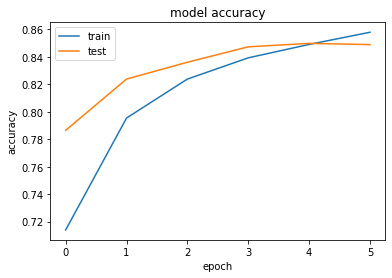

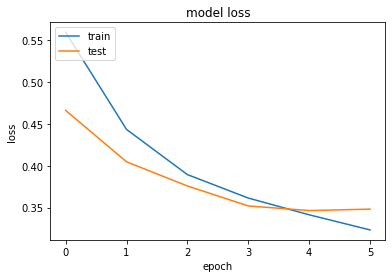

In [57]:
# Eğitim ve test setleri arasındaki kayıp ve doğruluk farklılıklarını açıkça görebilirsiniz.
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

<a id="6"></a>

<font color="purple">
    
# Text Classification with Recurrent Neural Network (Tekrarlayan sinir ağı) & LSTM

<font color="black" size="3">
    
Tekrarlayan sinir ağı, dizi verileriyle iyi çalıştığı kanıtlanmış bir sinir ağı türüdür.<br> Metin aslında bir kelime dizisi olduğundan, tekrarlayan bir sinir ağı metinle ilgili sorunları çözmek için otomatik bir seçimdir.<br>

Bu bölümde, duyarlılık (sentiment) sınıflandırma problemini çözmek için RNN'nin bir varyantı olan bir LSTM (Uzun Kısa Süreli Bellek ağı) kullanacağız.<br>

Bir kez daha, kelime gömme bölümüne kadar kodu yürütün ve bundan sonra aşağıdaki kod parçasını çalıştırın.

In [48]:
import tensorflow as tf
from tensorflow import keras

from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential



model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Yukarıdaki komut dosyasında, ardışık bir model başlatarak ardından gömme katmanının oluşturulmasını başlatacağız.Sonra, 128 nöron ile bir LSTM katmanı oluştururuz (nöron sayısı ile oynayabilirsiniz).
Modelimizin özetini çizelim.

In [49]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [50]:
# Bir sonraki adımımız modeli eğitim setinde eğitmek ve test setindeki performansını değerlendirmektir.

In [51]:
# Yukarıdaki komut dosyası, modeli test setinde eğitir. Parti büyüklüğü 128, çağ sayısı 6'dır. 
# Eğitimin sonunda, eğitim doğruluk oranının olduğunu göreceksiniz.

In [52]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 74s 2ms/step - loss: 0.5596 - acc: 0.7139 - val_loss: 0.4662 - val_acc: 0.7865
Epoch 2/6
32000/32000 [==============================] - 78s 2ms/step - loss: 0.4434 - acc: 0.7955 - val_loss: 0.4047 - val_acc: 0.8239
Epoch 3/6
32000/32000 [==============================] - 82s 3ms/step - loss: 0.3895 - acc: 0.8239 - val_loss: 0.3759 - val_acc: 0.8361
Epoch 4/6
32000/32000 [==============================] - 79s 2ms/step - loss: 0.3615 - acc: 0.8393 - val_loss: 0.3520 - val_acc: 0.8474
Epoch 5/6
32000/32000 [==============================] - 87s 3ms/step - loss: 0.3415 - acc: 0.8491 - val_loss: 0.3465 - val_acc: 0.8499
Epoch 6/6
10000/10000 [==============================] - 12s 1ms/step


In [58]:
# Model eğitildikten sonra, test komut dizisindeki model sonuçlarını aşağıdaki komut dosyasıyla görebiliriz:

In [59]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3443995174407959
Test Accuracy: 0.8481000065803528


In [60]:
# Epoch bilgilerine bakarsanız her bir epochta loss azalırken accuracy artmakta.

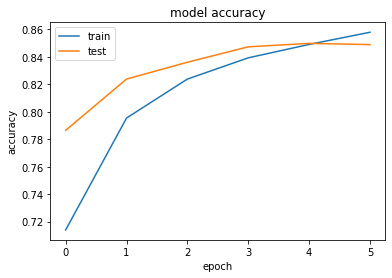

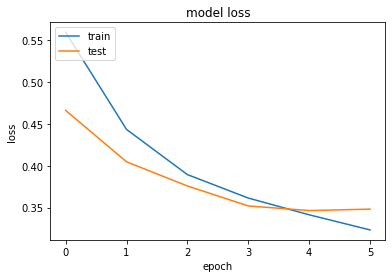

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# Ayşenur Kazan 1188132111